In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generación de datos

In [ ]:
from src.data_gen import generate_instances

instances = generate_instances(filename="TSP50.pkl", instance_count=100, cities=50, seed=42)

In [9]:
from src.data_gen import generate_train_data

generate_train_data(instance_file="TSP50.pkl", data_filename="TSP50_train_data.pkl")

In [13]:
instanciaDificil = generate_instances(filename="TSP_dificil.pkl", instance_count=10, cities=100, seed=42)

In [14]:
generate_train_data(instance_file="TSP_dificil.pkl", data_filename="TSP_dificil_train_data.pkl")

# Entrenamiento

In [4]:
from src.training import load_data

dataset = load_data(file_path="TSP50_data.pkl")

In [10]:
from src.models import TSPTransformer

# Parámetros del modelo
input_dim = 2
embed_dim = 128
num_heads = 8
head_dim = 32
num_layers = 3
dropout = 0.1

# Crear modelo
model = TSPTransformer(
    input_dim=input_dim,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout_rate=dropout
)

#model.init_weights()  # Inicializar pesos del modelo

In [6]:
from src.training import train

epochs = 250
train_size = 1000
test_size = 200
batch_size = 32
learning_rate = 1e-4
seed = 42

stats = train(model, dataset, epochs, train_size, test_size, batch_size, learning_rate, seed)

Usando dispositivo: cuda
Epoch 1/250 - Train Loss: 3.8679, Train Accuracy: 6.70% - Val Loss: 3.8671, Val Accuracy: 15.00%
Epoch 2/250 - Train Loss: 3.8683, Train Accuracy: 5.90% - Val Loss: 3.8671, Val Accuracy: 11.50%
Epoch 3/250 - Train Loss: 3.8658, Train Accuracy: 7.40% - Val Loss: 3.8670, Val Accuracy: 11.50%
Epoch 4/250 - Train Loss: 3.8682, Train Accuracy: 6.80% - Val Loss: 3.8670, Val Accuracy: 12.00%
Epoch 5/250 - Train Loss: 3.8659, Train Accuracy: 7.20% - Val Loss: 3.8668, Val Accuracy: 11.50%
Epoch 6/250 - Train Loss: 3.8642, Train Accuracy: 7.80% - Val Loss: 3.8666, Val Accuracy: 12.50%
Epoch 7/250 - Train Loss: 3.8679, Train Accuracy: 7.40% - Val Loss: 3.8662, Val Accuracy: 12.50%
Epoch 8/250 - Train Loss: 3.8676, Train Accuracy: 6.70% - Val Loss: 3.8666, Val Accuracy: 12.00%
Epoch 9/250 - Train Loss: 3.8651, Train Accuracy: 7.00% - Val Loss: 3.8664, Val Accuracy: 12.00%
Epoch 10/250 - Train Loss: 3.8651, Train Accuracy: 8.70% - Val Loss: 3.8653, Val Accuracy: 12.00%
Epoc

In [7]:
from src.training import save_model
save_model(model, filename="model_bueno.pth")

In [11]:
from src.training import load_model
model = load_model(model, filename="model_bueno.pth")

# Validación

Predicted cost: 6.487828569005518


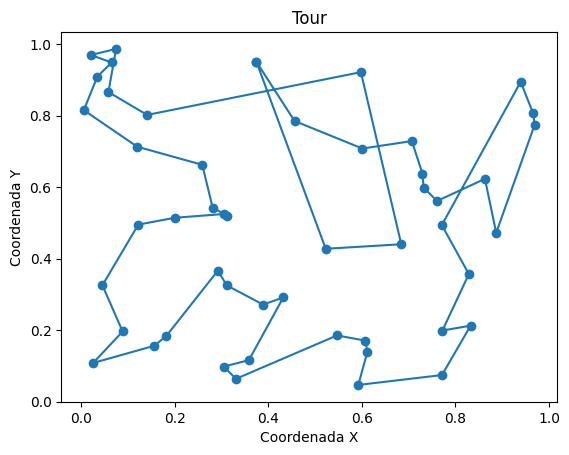

Predicted cost: 9.417529132518354


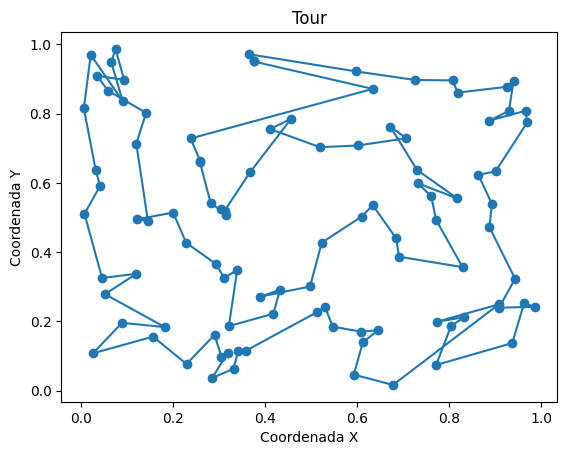

In [15]:
from src.solvers.model import ModelSolver

model_solver = ModelSolver(model)
model_sol = model_solver.solve(instance_file="TSP50.pkl", instance_number=0)

print("Predicted cost:", model_sol.cost)
model_sol.plot()

model_sol = model_solver.solve(instance_file="TSP_dificil.pkl", instance_number=0)
print("Predicted cost:", model_sol.cost)
model_sol.plot()

Optimal cost: 5.393124245897437


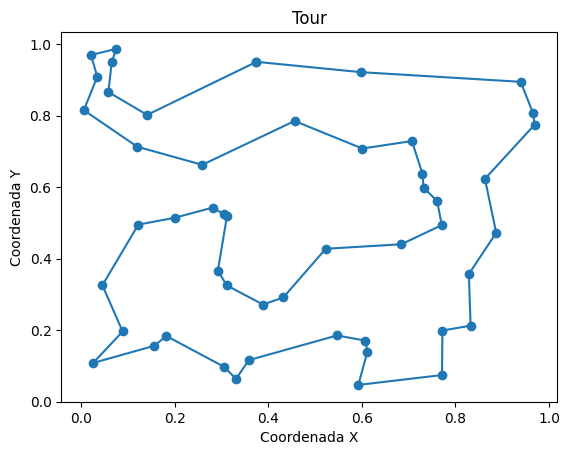

Optimal cost (difficult instance): 7.7235437730483625


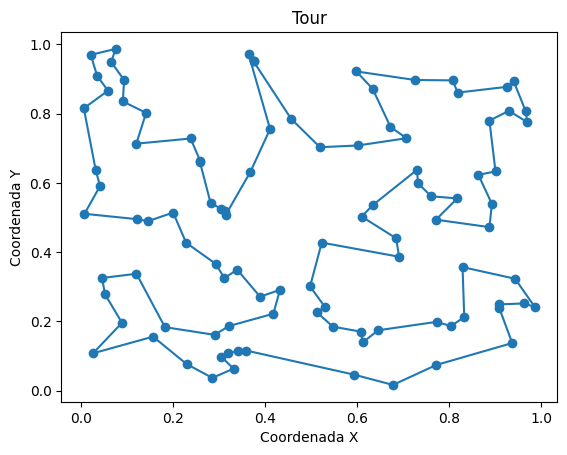

In [16]:
from src.data_gen import read_instances
from src.solvers.ortools import solve

instances = read_instances("TSP50.pkl")
instance = instances[0]
ortools_sol = solve(instance)
print("Optimal cost:", ortools_sol.cost)
ortools_sol.plot()

instanciaDif = read_instances("TSP_dificil.pkl")
instanceDificil = instanciaDif[0]
ortools_sol_dificil = solve(instanceDificil)
print("Optimal cost (difficult instance):", ortools_sol_dificil.cost)
ortools_sol_dificil.plot()

In [ ]:
from src.solvers.ortools import solve
from src.solvers.model import ModelSolver

instances = read_instances("TSP50.pkl")
model_costs = []
opt_costs = []

model_solver = ModelSolver(model)

for i, instance in enumerate(instances):
    model_sol = model_solver.solve(instance_file="TSP50.pkl", instance_number=i)
    ortools_sol = solve(instance)

    model_costs.append(model_sol.cost)
    opt_costs.append(ortools_sol.cost)

print("Avg gap (%):", sum((mc - oc) / oc * 100 for mc, oc in zip(model_costs, opt_costs)) / len(opt_costs))

Avg gap (%): 7.177289038275786


### Comprobar gap promedio con la data de validacion

In [ ]:
import torch
import numpy as np
import os

def validate_and_gap(model, npz_path, device, batch_size=50):
    print(f"--- Cargando datos de: {npz_path} ---")
    
    # CORRECCIÓN 1: Añadir allow_pickle=True para permitir leer arrays de objetos
    data = np.load(npz_path, allow_pickle=True)
    
    # CORRECCIÓN 2: Manejo seguro de tipos
    # points suele ser float, solutions suele ser int
    points_np = data['points']
    solutions_np = data['solutions']
    
    # Si solutions se cargó como objetos (lists), forzamos la conversión a int64
    # Esto previene errores al convertir a Tensor
    if solutions_np.dtype == object:
        # Probamos conversión directa (si es rectangular)
        try:
            solutions_np = solutions_np.astype(np.int64)
        except ValueError:
            # Si falla (ej: listas de distinto tamaño), lo convertimos vía lista
            # (Aunque para usar torch.tensor deben ser del mismo tamaño)
            solutions_np = np.array(solutions_np.tolist(), dtype=np.int64)

    # Convertimos a tensores
    all_points = torch.tensor(points_np, dtype=torch.float32).to(device)
    all_solutions = torch.tensor(solutions_np, dtype=torch.long).to(device)
    
    num_samples = all_points.size(0)
    model.eval() 
    
    total_gap = 0
    total_opt_cost = 0
    total_model_cost = 0
    
    print(f"Validando {num_samples} instancias en batches de {batch_size}...")
    
    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            # Control para el último batch si no es exacto
            points_batch = all_points[i : i + batch_size]
            opt_sol_batch = all_solutions[i : i + batch_size]
            
            # Calcular Costo Óptimo
            opt_costs = calculate_batch_distance(points_batch, opt_sol_batch)
            
            # Generar Solución del Modelo
            model_tour_indices = greedy_inference(model, points_batch, device)
            
            # Calcular Costo del Modelo
            model_costs = calculate_batch_distance(points_batch, model_tour_indices)
            
            # Calcular Gap
            # Evitamos división por cero sumando un epsilon si fuera necesario, 
            # pero en TSP las distancias suelen ser > 0
            gap = (model_costs - opt_costs) / opt_costs
            
            total_gap += gap.sum().item()
            total_opt_cost += opt_costs.sum().item()
            total_model_cost += model_costs.sum().item()
            
            if (i // batch_size) % 10 == 0:
                print(f"Batch {i//batch_size + 1}: Gap promedio parcial = {gap.mean().item()*100:.2f}%")

    avg_gap = (total_gap / num_samples) * 100
    avg_model_cost = total_model_cost / num_samples
    avg_opt_cost = total_opt_cost / num_samples
    
    print("\n" + "="*30)
    print(f"RESULTADOS FINALES")
    print("="*30)
    print(f"Costo Promedio Modelo: {avg_model_cost:.4f}")
    print(f"Costo Promedio Óptimo: {avg_opt_cost:.4f}")
    print(f"GAP PROMEDIO:          {avg_gap:.4f}%")
    print("="*30)
    
    return avg_gap

# --- Función de Inferencia Vectorizada (Batch) ---
# Esta es mucho más rápida que el bucle while de ModelSolver
def greedy_inference(model, coordinates, device):
    batch_size, num_nodes, _ = coordinates.shape
    visited_mask = torch.zeros((batch_size, num_nodes), dtype=torch.int32, device=device)
    tour_indices_list = []
    
    # Asumimos que empezamos en alguna ciudad o dejamos que el modelo elija la primera
    # Si tu modelo requiere un token de inicio especial, ajústalo aquí.
    # Comúnmente en TSP se empieza eligiendo libremente.
    
    for _ in range(num_nodes):
        # Forward pass
        # Asegúrate que tu modelo acepte (coords, mask)
        logits = model(coordinates, visited_mask) 
        
        # Enmascarar visitados
        logits = logits.masked_fill(visited_mask.bool(), float('-inf'))
        
        # Greedy choice
        next_city = logits.argmax(dim=1)
        
        # Guardar y actualizar máscara
        tour_indices_list.append(next_city)
        visited_mask.scatter_(1, next_city.unsqueeze(1), 1)
        
    return torch.stack(tour_indices_list, dim=1)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(DEVICE)
NPZ_FILE = "src/tsp_hard_val_part_0.npz" # El archivo que subiste

avg_gap= validate_and_gap(model, NPZ_FILE, DEVICE)

--- Cargando datos de: src/tsp_hard_val_part_0.npz ---
Validando 100 instancias en batches de 50...


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)